In [1]:
import os
import errno
import random
import shutil
import zipfile
import skimage.io as io

import numpy as np
from tensorflow.python import keras

from deepcell.utils.data_utils import make_training_data
from deepcell.utils.data_utils import get_data
from deepcell.utils.io_utils import get_image_sizes
from deepcell.utils.export_utils import export_model
from deepcell.utils.train_utils import rate_scheduler
from deepcell.model_zoo import bn_feature_net_2D
from deepcell.model_zoo import bn_feature_net_skip_2D
from deepcell.training import train_model_sample
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/deepcell/utils/__init__.py:49: UserWarning: To use `compute_overlap`, the C extensions must be built using `python setup.py build_ext --inplace`
  warnings.warn('To use `compute_overlap`, the C extensions must be built '


In [118]:
CHANNEL_AXIS = 3
training_data = np.load(os.path.join('/data/npz_data', 
                                     "Point1_12_18_23_3X_interior_border_border" + ".npz"))

X, y = training_data["X"], training_data["y"]
print("X.shape: {} & y.shape: {}".format(X.shape, y.shape))


X.shape: (4, 1024, 1024, 3) & y.shape: (4, 1024, 1024, 1)


In [87]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# Sample mode settings
batch_size = 64  # number of images per batch (should be 2 ^ n)
win = (receptive_field - 1) // 2  # sample window size
balance_classes = True  # sample each class equally
max_class_samples = 1e6  # max number of samples per class

# Transformation settings
transform = 'watershed'
distance_bins = 4  # number of distance "classes"
erosion_width = 1  # erode edges

In [90]:
hist = np.load('/data/models/20190525_watershed_retrain/Point1_12_18_3X_interior_watershed.npz')
hist['loss_history'].tolist()['acc']

[0.6144102436510335,
 0.6336170893376529,
 0.6389264070802751,
 0.6422830510604277,
 0.6448688443025397,
 0.6474812952048338,
 0.6502137055948961,
 0.6520886278433811,
 0.653039417795596,
 0.6555696742454853]

In [141]:
base_model_name = 'Point1_12_18_3X_interior_border'
folder_name = '20190525_watershed_retrain'
epoch_name_fgbg = "_epoch_01"
epoch_name_watershed = "_epoch_40"

fgbg_MODEL_NAME = 'Point1_12_18_3X_interior' + '_fgbg'  + epoch_name_fgbg
fgbg_weights_file = os.path.join('/data/models/20190505_watershed_retrain/', fgbg_MODEL_NAME + ".h5")

watershed_MODEL_NAME = base_model_name + '_watershed'  + epoch_name_watershed
watershed_weights_file = os.path.join('/data/models', folder_name, watershed_MODEL_NAME + ".h5")

In [119]:
X = X[:, :, :, 0:2]

In [142]:
# load fgbg model
from deepcell import model_zoo
# run_fgbg_model = model_zoo.bn_feature_net_2D(
#     receptive_field=receptive_field,
#     dilated=True,
#     n_features=2,
#     input_shape=(1024, 1024, 1))
# run_fgbg_model.load_weights(fgbg_weights_file)

run_watershed_model = model_zoo.bn_feature_net_2D(
    dilated=True,
    receptive_field=receptive_field,
    n_features=distance_bins,
    input_shape=tuple(X.shape[1:]))
run_watershed_model.load_weights(watershed_weights_file)

In [143]:
# run the two models
test_images = run_watershed_model.predict(X)
#test_images_fgbg = run_fgbg_model.predict(X[:, :, :, 0:1])

In [93]:
# np.save(os.path.join('/data/models', folder_name, fgbg_MODEL_NAME + "_metrics"), test_images_fgbg)

In [144]:
# combine outputs together for saving
test_images_combo = np.zeros((4,1024,1024,6))
test_images_combo[:, :, :, 0:4] = test_images
test_images_combo[:, :, :, 4:] = test_images_fgbg

In [145]:
np.save(os.path.join('/data/models', folder_name, watershed_MODEL_NAME + "_metrics"), test_images_combo)

In [24]:
test_2 = np.load('/notebooks/Noah_Scripts/notebooks/output/models/' + 'Point1_12_18_3X_interior_save_10' + '_metrics.npy')

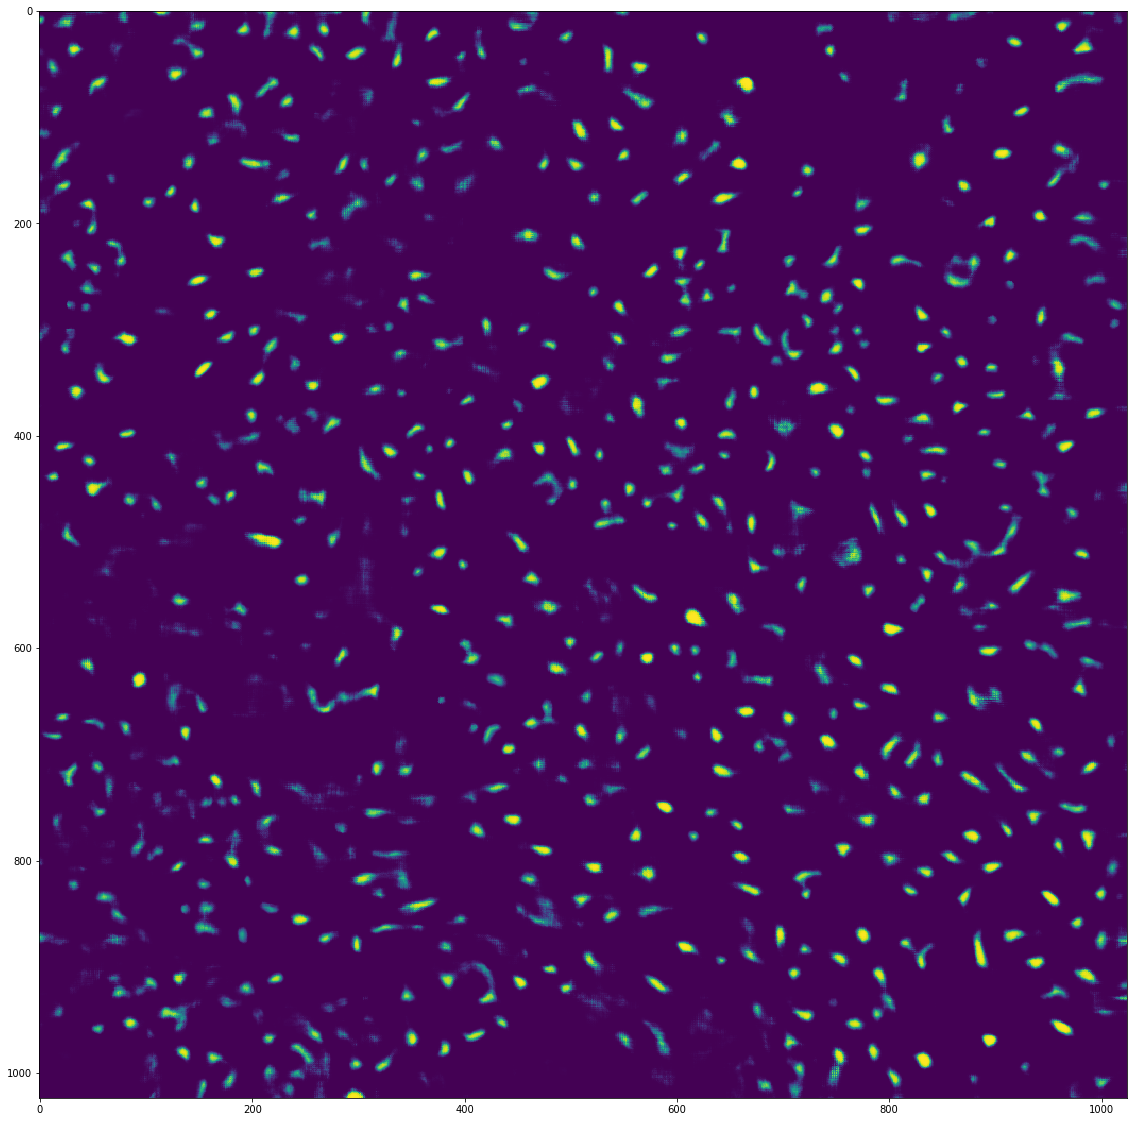

In [147]:
plt.figure(figsize = (20, 20))
plt.imshow(test_images[3, :, :, 3])